In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Deep Learning

/content/drive/.shortcut-targets-by-id/1Trxl5w_1Idhx5oEXi3LgMQlXibn4lhf0/Deep Learning


#Dataset

In [ ]:
# Install or upgrade the 'opendatasets' library using pip
!pip install opendatasets --upgrade --quiet

In [ ]:
# Import the opendatasets library
import opendatasets as od

# Specify the URL of the Kaggle dataset
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'

# Download the dataset using the opendatasets library
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dhirajpimparkar
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:07<00:00, 55.1MB/s]


In [ ]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))


['images']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn.functional as F
# Import PyTorch and necessary modules
import torch
from torchvision.utils import make_grid
import torch.nn as nn
# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

In [ ]:
# Set the desired size for the images (assuming square images)
image_size = 64

# Set the batch size for data loading
batch_size = 128

# Define the normalization statistics for image preprocessing
# The statistics are usually mean and standard deviation for each color channel (RGB)
# The format is (mean_R, mean_G, mean_B), (std_R, std_G, std_B)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
# Define the transformation pipeline for the training dataset
# The pipeline includes resizing, center cropping, converting to tensor, and normalization
transform_pipeline = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

# Create the training dataset using the ImageFolder class and apply the transformation
train_ds = ImageFolder(DATA_DIR, transform=transform_pipeline)

# Create the DataLoader for the training dataset
# DataLoader is responsible for providing batches of data during training
# It shuffles the data, uses multiple workers for loading, and can be pinned to memory for acceleration
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
train_ds

Dataset ImageFolder
    Number of datapoints: 63565
    Root location: ./animefacedataset
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
def denorm(img_tensors):
    """
    Denormalize image tensors.

    Args:
    - img_tensors (torch.Tensor): Input image tensor(s) to be denormalized.

    Returns:
    - torch.Tensor: Denormalized image tensor(s).
    """
    # Denormalization formula: (img * std) + mean
    # For simplicity, assuming a single channel (e.g., grayscale) in the normalization stats
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    """
    Display a grid of images.

    Args:
    - images (torch.Tensor): Input image tensor(s) to be displayed.
    - nmax (int): Maximum number of images to display (default is 64).
    """
    # Create a subplot with no ticks
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])

    # Denormalize and display the image grid
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


def show_batch(dl, nmax=64):
    """
    Display a batch of images from a DataLoader.

    Args:
    - dl (DataLoader): DataLoader providing batches of images.
    - nmax (int): Maximum number of images to display (default is 64).
    """
    # Iterate over batches in the DataLoader
    for images, _ in dl:
        # Display the images in the batch
        show_images(images, nmax)
        # Display only the first batch for simplicity
        break


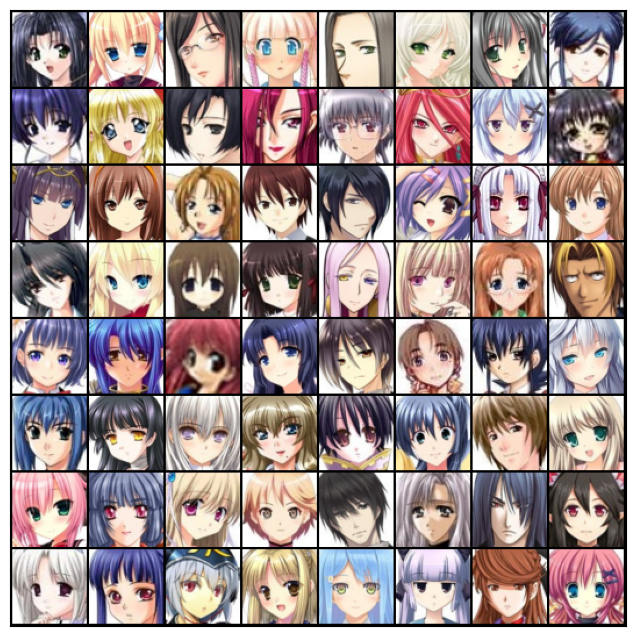

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')  # Return a CUDA device if available
    else:
        return torch.device('cpu')  # Return a CPU device if no CUDA device is available

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        # Recursively move each element of the list or tuple to the specified device
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)  # Move the tensor to the specified device

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)  # Yield a batch of data after moving it to the specified device

    def __len__(self):
        """Number of batches"""
        return len(self.dl)  # Return the number of batches in the wrapped dataloader


In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
# Define the discriminator neural network architecture
discriminator = nn.Sequential(
    # Convolutional layer 1: Input channels (3 for RGB), output channels (64), kernel size (4x4),
    # stride (2), padding (1), no bias term, followed by batch normalization and LeakyReLU activation
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Output: 64 channels, 32 x 32 spatial dimensions

    # Convolutional layer 2: Input channels (64), output channels (128), kernel size (4x4),
    # stride (2), padding (1), no bias term, followed by batch normalization and LeakyReLU activation
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Output: 128 channels, 16 x 16 spatial dimensions

    # Convolutional layer 3: Input channels (128), output channels (256), kernel size (4x4),
    # stride (2), padding (1), no bias term, followed by batch normalization and LeakyReLU activation
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # Output: 256 channels, 8 x 8 spatial dimensions

    # Convolutional layer 4: Input channels (256), output channels (512), kernel size (4x4),
    # stride (2), padding (1), no bias term, followed by batch normalization and LeakyReLU activation
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # Output: 512 channels, 4 x 4 spatial dimensions

    # Convolutional layer 5: Input channels (512), output channels (1), kernel size (4x4),
    # stride (1), no padding, no bias term, followed by flattening and Sigmoid activation
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # Output: 1 channel, 1 x 1 spatial dimensions

    # Flatten the output tensor to a 1D tensor
    nn.Flatten(),
    # Apply Sigmoid activation to the flattened tensor
    nn.Sigmoid()
)


In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
import torch.nn as nn

# Define the size of the latent vector
latent_size = 128

# Define the generator neural network architecture
generator = nn.Sequential(
    # Transposed convolutional layer 1: Input channels (latent_size), output channels (512),
    # kernel size (4x4), stride (1), no padding, no bias term,
    # followed by batch normalization and ReLU activation
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Output: 512 channels, 4 x 4 spatial dimensions

    # Transposed convolutional layer 2: Input channels (512), output channels (256),
    # kernel size (4x4), stride (2), padding (1), no bias term,
    # followed by batch normalization and ReLU activation
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Output: 256 channels, 8 x 8 spatial dimensions

    # Transposed convolutional layer 3: Input channels (256), output channels (128),
    # kernel size (4x4), stride (2), padding (1), no bias term,
    # followed by batch normalization and ReLU activation
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Output: 128 channels, 16 x 16 spatial dimensions

    # Transposed convolutional layer 4: Input channels (128), output channels (64),
    # kernel size (4x4), stride (2), padding (1), no bias term,
    # followed by batch normalization and ReLU activation
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Output: 64 channels, 32 x 32 spatial dimensions

    # Transposed convolutional layer 5: Input channels (64), output channels (3),
    # kernel size (4x4), stride (2), padding (1), no bias term,
    # followed by Tanh activation (to ensure output values are in the range [-1, 1])
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # Output: 3 channels (RGB), 64 x 64 spatial dimensions
)


In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)  # Forward pass for real images
    real_targets = torch.ones(real_images.size(0), 1, device=device)  # Real labels
    real_loss = F.binary_cross_entropy(real_preds, real_targets)  # Binary cross-entropy loss
    real_score = torch.mean(real_preds).item()  # Mean prediction score for real images

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Generate random latent vectors
    fake_images = generator(latent)  # Generate fake images using the generator

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)  # Fake labels
    fake_preds = discriminator(fake_images)  # Forward pass for fake images
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)  # Binary cross-entropy loss
    fake_score = torch.mean(fake_preds).item()  # Mean prediction score for fake images

    # Update discriminator weights
    loss = real_loss + fake_loss  # Total loss for the discriminator
    loss.backward()  # Backpropagation
    opt_d.step()  # Update discriminator weights
    return loss.item(), real_score, fake_score


In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Generate random latent vectors
    fake_images = generator(latent)  # Generate fake images using the generator

    # Try to fool the discriminator
    preds = discriminator(fake_images)  # Forward pass for fake images through the discriminator
    targets = torch.ones(batch_size, 1, device=device)  # Target labels (ones)
    loss = F.binary_cross_entropy(preds, targets)  # Binary cross-entropy loss

    # Update generator weights
    loss.backward()  # Backpropagation
    opt_g.step()  # Update generator weights

    return loss.item()  # Return the loss value as a scalar


Saving generated-images-0000.png


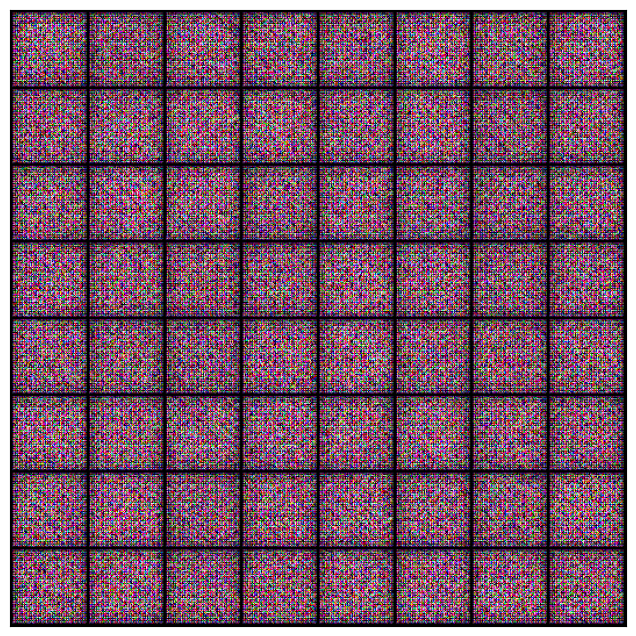

In [ ]:
from torchvision.utils import save_image

# Specify the directory for saving generated samples
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    # Generate fake images using the generator
    fake_images = generator(latent_tensors)

    # Create a filename for the saved image
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)

    # Save the generated images to the specified directory
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)

    # Optionally display the generated images
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        # Display the generated images in a grid using matplotlib
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

# Generate fixed latent vectors for consistent sample generation
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

# Save and optionally display generated samples using the fixed latent vectors
save_samples(0, fixed_latent)


In [ ]:
from tqdm import tqdm
def fit(epochs, lr, start_idx=1):
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Lists to store losses and scores during training
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers for the discriminator and generator
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Training loop
    for epoch in range(epochs):
        # Iterate over batches in the training DataLoader
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores for the epoch
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores for the last batch of the epoch
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images for the epoch
        save_samples(epoch+start_idx, fixed_latent, show=False)

    # Return the recorded losses and scores
    return losses_g, losses_d, real_scores, fake_scores


In [ ]:
lr = 0.0002
epochs = 100
history = fit(epochs, lr)

100%|██████████| 497/497 [02:10<00:00,  3.81it/s]


Epoch [1/100], loss_g: 9.6742, loss_d: 0.1866, real_score: 0.8994, fake_score: 0.0006
Saving generated-images-0001.png


100%|██████████| 497/497 [02:06<00:00,  3.94it/s]


Epoch [2/100], loss_g: 17.7464, loss_d: 0.0264, real_score: 0.9826, fake_score: 0.0056
Saving generated-images-0002.png


100%|██████████| 497/497 [02:07<00:00,  3.90it/s]


Epoch [3/100], loss_g: 12.8929, loss_d: 0.1443, real_score: 0.9177, fake_score: 0.0016
Saving generated-images-0003.png


100%|██████████| 497/497 [02:08<00:00,  3.86it/s]


Epoch [4/100], loss_g: 6.5987, loss_d: 0.0401, real_score: 0.9756, fake_score: 0.0093
Saving generated-images-0004.png


100%|██████████| 497/497 [02:07<00:00,  3.91it/s]


Epoch [5/100], loss_g: 7.8542, loss_d: 0.1162, real_score: 0.9642, fake_score: 0.0635
Saving generated-images-0005.png


100%|██████████| 497/497 [02:06<00:00,  3.94it/s]


Epoch [6/100], loss_g: 6.9745, loss_d: 0.0107, real_score: 0.9927, fake_score: 0.0032
Saving generated-images-0006.png


100%|██████████| 497/497 [02:10<00:00,  3.82it/s]


Epoch [7/100], loss_g: 10.9249, loss_d: 0.0097, real_score: 0.9912, fake_score: 0.0006
Saving generated-images-0007.png


100%|██████████| 497/497 [02:06<00:00,  3.92it/s]


Epoch [8/100], loss_g: 7.9386, loss_d: 0.0270, real_score: 0.9883, fake_score: 0.0143
Saving generated-images-0008.png


100%|██████████| 497/497 [02:05<00:00,  3.97it/s]


Epoch [9/100], loss_g: 8.3464, loss_d: 0.0666, real_score: 0.9863, fake_score: 0.0481
Saving generated-images-0009.png


100%|██████████| 497/497 [02:09<00:00,  3.84it/s]


Epoch [10/100], loss_g: 9.1789, loss_d: 1.2412, real_score: 0.4894, fake_score: 0.0000
Saving generated-images-0010.png


100%|██████████| 497/497 [02:07<00:00,  3.91it/s]


Epoch [11/100], loss_g: 15.3955, loss_d: 0.2353, real_score: 0.9999, fake_score: 0.1651
Saving generated-images-0011.png


100%|██████████| 497/497 [02:05<00:00,  3.95it/s]


Epoch [12/100], loss_g: 7.0277, loss_d: 0.0386, real_score: 0.9936, fake_score: 0.0308
Saving generated-images-0012.png


100%|██████████| 497/497 [02:09<00:00,  3.85it/s]


Epoch [13/100], loss_g: 7.4858, loss_d: 0.0507, real_score: 0.9732, fake_score: 0.0041
Saving generated-images-0013.png


100%|██████████| 497/497 [02:07<00:00,  3.89it/s]


Epoch [14/100], loss_g: 12.9785, loss_d: 0.1474, real_score: 0.9997, fake_score: 0.1133
Saving generated-images-0014.png


100%|██████████| 497/497 [02:05<00:00,  3.97it/s]


Epoch [15/100], loss_g: 10.5471, loss_d: 0.0128, real_score: 0.9990, fake_score: 0.0114
Saving generated-images-0015.png


100%|██████████| 497/497 [02:08<00:00,  3.87it/s]


Epoch [16/100], loss_g: 4.7592, loss_d: 0.0891, real_score: 0.9505, fake_score: 0.0132
Saving generated-images-0016.png


100%|██████████| 497/497 [02:05<00:00,  3.95it/s]


Epoch [17/100], loss_g: 8.0911, loss_d: 0.0533, real_score: 0.9767, fake_score: 0.0165
Saving generated-images-0017.png


100%|██████████| 497/497 [02:07<00:00,  3.89it/s]


Epoch [18/100], loss_g: 6.4661, loss_d: 0.0420, real_score: 0.9803, fake_score: 0.0183
Saving generated-images-0018.png


100%|██████████| 497/497 [02:09<00:00,  3.82it/s]


Epoch [19/100], loss_g: 5.6459, loss_d: 0.0847, real_score: 0.9692, fake_score: 0.0305
Saving generated-images-0019.png


100%|██████████| 497/497 [02:07<00:00,  3.90it/s]


Epoch [20/100], loss_g: 6.8179, loss_d: 0.0481, real_score: 0.9843, fake_score: 0.0293
Saving generated-images-0020.png


100%|██████████| 497/497 [02:07<00:00,  3.90it/s]


Epoch [21/100], loss_g: 21.2451, loss_d: 0.0090, real_score: 0.9916, fake_score: 0.0001
Saving generated-images-0021.png


100%|██████████| 497/497 [02:08<00:00,  3.87it/s]


Epoch [22/100], loss_g: 7.2699, loss_d: 0.0230, real_score: 0.9880, fake_score: 0.0102
Saving generated-images-0022.png


100%|██████████| 497/497 [02:11<00:00,  3.79it/s]


Epoch [23/100], loss_g: 9.0834, loss_d: 0.0520, real_score: 1.0000, fake_score: 0.0472
Saving generated-images-0023.png


100%|██████████| 497/497 [02:11<00:00,  3.77it/s]


Epoch [24/100], loss_g: 8.9300, loss_d: 0.1192, real_score: 0.9300, fake_score: 0.0024
Saving generated-images-0024.png


100%|██████████| 497/497 [02:14<00:00,  3.71it/s]


Epoch [25/100], loss_g: 5.1029, loss_d: 0.0259, real_score: 0.9901, fake_score: 0.0148
Saving generated-images-0025.png


100%|██████████| 497/497 [02:10<00:00,  3.80it/s]


Epoch [26/100], loss_g: 6.8874, loss_d: 0.0273, real_score: 0.9881, fake_score: 0.0145
Saving generated-images-0026.png


100%|██████████| 497/497 [02:08<00:00,  3.88it/s]


Epoch [27/100], loss_g: 17.0442, loss_d: 0.0256, real_score: 0.9857, fake_score: 0.0069
Saving generated-images-0027.png


100%|██████████| 497/497 [02:09<00:00,  3.84it/s]


Epoch [28/100], loss_g: 7.9309, loss_d: 0.0263, real_score: 0.9923, fake_score: 0.0178
Saving generated-images-0028.png


100%|██████████| 497/497 [02:06<00:00,  3.94it/s]


Epoch [29/100], loss_g: 11.1993, loss_d: 0.1152, real_score: 0.9944, fake_score: 0.1017
Saving generated-images-0029.png


100%|██████████| 497/497 [02:08<00:00,  3.88it/s]


Epoch [30/100], loss_g: 7.3402, loss_d: 0.0096, real_score: 0.9998, fake_score: 0.0093
Saving generated-images-0030.png


100%|██████████| 497/497 [02:10<00:00,  3.82it/s]


Epoch [31/100], loss_g: 6.8810, loss_d: 0.0188, real_score: 0.9881, fake_score: 0.0025
Saving generated-images-0031.png


100%|██████████| 497/497 [02:06<00:00,  3.92it/s]


Epoch [32/100], loss_g: 32.8154, loss_d: 0.0016, real_score: 0.9995, fake_score: 0.0011
Saving generated-images-0032.png


100%|██████████| 497/497 [02:05<00:00,  3.95it/s]


Epoch [33/100], loss_g: 6.0159, loss_d: 0.0994, real_score: 0.9681, fake_score: 0.0278
Saving generated-images-0033.png


100%|██████████| 497/497 [02:09<00:00,  3.83it/s]


Epoch [34/100], loss_g: 9.0595, loss_d: 0.0474, real_score: 0.9674, fake_score: 0.0023
Saving generated-images-0034.png


100%|██████████| 497/497 [02:06<00:00,  3.93it/s]


Epoch [35/100], loss_g: 6.6751, loss_d: 0.0320, real_score: 0.9906, fake_score: 0.0205
Saving generated-images-0035.png


100%|██████████| 497/497 [02:05<00:00,  3.95it/s]


Epoch [36/100], loss_g: 6.6854, loss_d: 0.0210, real_score: 0.9960, fake_score: 0.0167
Saving generated-images-0036.png


100%|██████████| 497/497 [02:09<00:00,  3.84it/s]


Epoch [37/100], loss_g: 8.7547, loss_d: 0.0553, real_score: 0.9998, fake_score: 0.0515
Saving generated-images-0037.png


100%|██████████| 497/497 [02:06<00:00,  3.92it/s]


Epoch [38/100], loss_g: 21.7938, loss_d: 0.0619, real_score: 0.9733, fake_score: 0.0216
Saving generated-images-0038.png


100%|██████████| 497/497 [02:07<00:00,  3.90it/s]


Epoch [39/100], loss_g: 11.9689, loss_d: 0.0300, real_score: 0.9998, fake_score: 0.0287
Saving generated-images-0039.png


100%|██████████| 497/497 [02:08<00:00,  3.88it/s]


Epoch [40/100], loss_g: 6.1381, loss_d: 0.0250, real_score: 0.9976, fake_score: 0.0218
Saving generated-images-0040.png


100%|██████████| 497/497 [02:07<00:00,  3.91it/s]


Epoch [41/100], loss_g: 7.7706, loss_d: 0.0415, real_score: 0.9695, fake_score: 0.0002
Saving generated-images-0041.png


100%|██████████| 497/497 [02:04<00:00,  3.99it/s]


Epoch [42/100], loss_g: 5.5213, loss_d: 0.0501, real_score: 0.9722, fake_score: 0.0131
Saving generated-images-0042.png


100%|██████████| 497/497 [02:11<00:00,  3.79it/s]


Epoch [43/100], loss_g: 12.4950, loss_d: 0.0257, real_score: 0.9895, fake_score: 0.0097
Saving generated-images-0043.png


100%|██████████| 497/497 [02:06<00:00,  3.92it/s]


Epoch [44/100], loss_g: 15.1434, loss_d: 0.0190, real_score: 0.9925, fake_score: 0.0105
Saving generated-images-0044.png


100%|██████████| 497/497 [02:05<00:00,  3.96it/s]


Epoch [45/100], loss_g: 25.8750, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0045.png


100%|██████████| 497/497 [02:11<00:00,  3.78it/s]


Epoch [46/100], loss_g: 8.0147, loss_d: 0.0498, real_score: 0.9973, fake_score: 0.0420
Saving generated-images-0046.png


100%|██████████| 497/497 [02:05<00:00,  3.96it/s]


Epoch [47/100], loss_g: 7.4558, loss_d: 0.0510, real_score: 0.9770, fake_score: 0.0212
Saving generated-images-0047.png


100%|██████████| 497/497 [02:05<00:00,  3.95it/s]


Epoch [48/100], loss_g: 8.1715, loss_d: 0.0233, real_score: 0.9983, fake_score: 0.0208
Saving generated-images-0048.png


100%|██████████| 497/497 [02:11<00:00,  3.79it/s]


Epoch [49/100], loss_g: 42.4633, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0049.png


100%|██████████| 497/497 [02:05<00:00,  3.97it/s]


Epoch [50/100], loss_g: 7.3146, loss_d: 0.0848, real_score: 0.9879, fake_score: 0.0659
Saving generated-images-0050.png


100%|██████████| 497/497 [02:06<00:00,  3.93it/s]


Epoch [51/100], loss_g: 31.5032, loss_d: 0.0196, real_score: 0.9931, fake_score: 0.0112
Saving generated-images-0051.png


100%|██████████| 497/497 [02:09<00:00,  3.83it/s]


Epoch [52/100], loss_g: 8.4848, loss_d: 0.0203, real_score: 0.9999, fake_score: 0.0189
Saving generated-images-0052.png


100%|██████████| 497/497 [02:04<00:00,  3.99it/s]


Epoch [53/100], loss_g: 11.6353, loss_d: 0.0017, real_score: 0.9990, fake_score: 0.0008
Saving generated-images-0053.png


100%|██████████| 497/497 [02:04<00:00,  4.00it/s]


Epoch [54/100], loss_g: 9.8417, loss_d: 0.0572, real_score: 0.9702, fake_score: 0.0156
Saving generated-images-0054.png


100%|██████████| 497/497 [02:09<00:00,  3.83it/s]


Epoch [55/100], loss_g: 10.3281, loss_d: 0.1651, real_score: 0.9237, fake_score: 0.0254
Saving generated-images-0055.png


100%|██████████| 497/497 [02:05<00:00,  3.96it/s]


Epoch [56/100], loss_g: 8.1985, loss_d: 0.0136, real_score: 0.9994, fake_score: 0.0128
Saving generated-images-0056.png


100%|██████████| 497/497 [02:04<00:00,  3.99it/s]


Epoch [57/100], loss_g: 5.5616, loss_d: 0.0099, real_score: 0.9946, fake_score: 0.0042
Saving generated-images-0057.png


100%|██████████| 497/497 [02:08<00:00,  3.87it/s]


Epoch [58/100], loss_g: 13.1807, loss_d: 0.0024, real_score: 0.9979, fake_score: 0.0001
Saving generated-images-0058.png


100%|██████████| 497/497 [02:06<00:00,  3.93it/s]


Epoch [59/100], loss_g: 44.2052, loss_d: 0.0470, real_score: 0.9790, fake_score: 0.0000
Saving generated-images-0059.png


100%|██████████| 497/497 [02:04<00:00,  3.98it/s]


Epoch [60/100], loss_g: 7.1208, loss_d: 0.0196, real_score: 0.9968, fake_score: 0.0161
Saving generated-images-0060.png


100%|██████████| 497/497 [02:09<00:00,  3.84it/s]


Epoch [61/100], loss_g: 18.7276, loss_d: 0.2762, real_score: 0.9999, fake_score: 0.1961
Saving generated-images-0061.png


100%|██████████| 497/497 [02:07<00:00,  3.90it/s]


Epoch [62/100], loss_g: 10.1720, loss_d: 0.0257, real_score: 0.9875, fake_score: 0.0101
Saving generated-images-0062.png


100%|██████████| 497/497 [02:07<00:00,  3.91it/s]


Epoch [63/100], loss_g: 9.4911, loss_d: 0.0155, real_score: 0.9941, fake_score: 0.0092
Saving generated-images-0063.png


100%|██████████| 497/497 [02:11<00:00,  3.78it/s]


Epoch [64/100], loss_g: 9.4439, loss_d: 0.0541, real_score: 0.9591, fake_score: 0.0008
Saving generated-images-0064.png


100%|██████████| 497/497 [02:07<00:00,  3.91it/s]


Epoch [65/100], loss_g: 8.8627, loss_d: 0.0138, real_score: 0.9948, fake_score: 0.0075
Saving generated-images-0065.png


100%|██████████| 497/497 [02:04<00:00,  3.99it/s]


Epoch [66/100], loss_g: 7.5082, loss_d: 0.0104, real_score: 0.9918, fake_score: 0.0017
Saving generated-images-0066.png


100%|██████████| 497/497 [02:06<00:00,  3.92it/s]


Epoch [67/100], loss_g: 13.4151, loss_d: 0.0209, real_score: 0.9850, fake_score: 0.0001
Saving generated-images-0067.png


100%|██████████| 497/497 [02:04<00:00,  4.00it/s]


Epoch [68/100], loss_g: 8.6542, loss_d: 0.0111, real_score: 1.0000, fake_score: 0.0110
Saving generated-images-0068.png


100%|██████████| 497/497 [02:05<00:00,  3.97it/s]


Epoch [69/100], loss_g: 7.6673, loss_d: 0.0279, real_score: 0.9962, fake_score: 0.0235
Saving generated-images-0069.png


100%|██████████| 497/497 [02:09<00:00,  3.84it/s]


Epoch [70/100], loss_g: 14.1984, loss_d: 0.0634, real_score: 0.9696, fake_score: 0.0042
Saving generated-images-0070.png


 52%|█████▏    | 257/497 [01:07<00:50,  4.72it/s]

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the trained generator model's state dictionary to a file
torch.save(generator.state_dict(), 'G.pth')

# Save the trained discriminator model's state dictionary to a file
torch.save(discriminator.state_dict(), 'D.pth')
